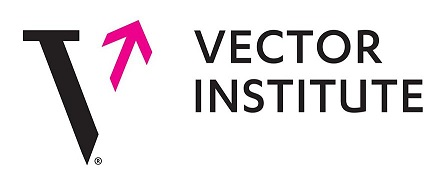
### **Welcome to the Bias in AI Course!**
This program is offered by Vector Institute in partnership with the CRA.

Instructor: Sayyed Nezhadi

Assignment Developer: Rishav Agarwal

Course Tutors: Reem Al-Saidi and Rishav Agarwal

Course Director: Melissa Valdez

### ***Never stop learning!***



### Assginment 2: Understanding text recognition from images. 

This assignment is split in two parts. First we will learn how to use a simple text recognition model and then in part two learn how to create a text detection model. You will understand how text information is extracted from images, and how object detection models are trained. Finally, you will be able to see realtime predicitions from the the same. 

The text recognition is based on [Google Tesseract](https://tesseract-ocr.github.io/tessdoc/Home.html)

Much of the data localization approach is based on the paper [DiT: Self-supervised Pre-training for Document Image Transformer](https://arxiv.org/abs/2203.02378)  and the code is adopted from this [git repo](https://github.com/microsoft/unilm/tree/master/dit)


**Submission Note:** Convert to pdf and submit PDFs. Notebooks will not be graded.

**Grade:** This assigment is graded on a 110 point scale but will contribute to 15% of your grade.

#### Changing Runtime

Change the runtime to use a GPU accelerator. You can use a free GPU on colab by selecting:

**Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

#### Installing Libraries

We will first install the relevant libraries. You may need to restart the instance (**Runtime** → **Restart Runtime**). Note that this needs to be done once.



In [ ]:
!sudo apt install tesseract-ocr python-enchant
!pip install pytesseract timm pyenchant
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!git clone https://github.com/microsoft/unilm.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
  tesseract-ocr-eng tesseract-ocr-osd
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko python-gobject python-gtk2
  python-wxgtk3.0
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
  python-enchant tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 14 newly installed, 0 to remove and 49 not upgraded.
Need to get 6,151 kB of archives.
Af

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-u67i1fk9
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-u67i1fk9
     |████████████████████████████████| 50 kB 3.3 MB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 151 kB 51.4 MB/s 
     |████████████████████████████████| 1.4 MB 55.4 MB/s 
     |████████████████████████████████| 248 kB 53.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 843 kB 44.8 MB/s 
     |████████████████████████████████| 96 kB 7.4 MB/s 
     |████████████████████████████████| 596 kB 58.0 MB/s 
     |████████████████████████████████| 117 kB 67.2 MB/s 
  Created whee

Cloning into 'unilm'...
remote: Enumerating objects: 6435, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6435 (delta 2), reused 1 (delta 0), pack-reused 6429
Receiving objects: 100% (6435/6435), 10.85 MiB | 21.00 MiB/s, done.
Resolving deltas: 100% (2892/2892), done.


### Part 1: Text Recognition using OCR [50]

#### Helper Functions

Here we will define some helper functions. You may change these if you need.*italicized text*


In [ ]:
import cv2
import pytesseract 
from matplotlib import pyplot as plt
import urllib.request as request
import numpy as np

def draw_text_on_image(img, results, min_conf = 0):
  '''
  '''
  im_w, im_h = img.shape[:2]
  text_img = np.ones((im_w, 2*im_h, 3))
  for i in range(len(results["text"])):    
      # Extract the bounding box coordinates

      x1, y1, x2, y2 = results["bbox"][i]
      
      # Extract the text and confidence of the text localization
      text = results["text"][i]
      conf = float(results["conf"][i])
      
      # filter out weak confidence text localizations
      if conf > min_conf and len(text) > 0:
          text =  "".join(text).strip()
          cv2.rectangle(img,
                        (x1, y1),
                        (x2, y2),
                        (0, 0, 255), 1)
          cv2.putText(text_img,
                      text,
                      (x1, y1),
                      cv2.FONT_HERSHEY_SIMPLEX,
                      .5, (0, 255, 255), 1)
  text_img[:, im_h:, : ] = img
  return text_img.astype(np.uint8)

def format_tesseract_output(result):
  '''
  '''
  result["bbox"] = []
  for i in range(len(result["text"])): 
      x = result["left"][i]
      y = result["top"][i]
      w = result["width"][i]
      h = result["height"][i]
      result["bbox"].append([x,y,x+w, y+h])
      result["conf"][i] = int(result["conf"][i])/100
  return result

def download_image(img_path):
  '''
  Given image path, downloads and returns the image in RGB format
  '''
  req = request.urlopen(img_path)
  arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
  full_img = cv2.imdecode(arr, -1) # 'Load it as it is'
  full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
  return full_img

def ocr_patch(full_img, crop = None, scale = 1, min_conf = .8, viz = False):
  '''
  Function to return 
  '''

  # Add cropping logic here
  if crop is not None:  
    # Code 
    x1, y1, x2, y2 =  crop
    img = full_img[x1:x2, y1:y2, :]
  else:
    img = full_img 
  width, height  = img.shape[:2]
  print(  width, height )
  img_scaled = cv2.resize(img, dsize = (int(width*scale), int(height*scale)))
  results = pytesseract.image_to_data(img_scaled, output_type=pytesseract.Output.DICT)
  results  = format_tesseract_output(results)
  if viz:
    plt.figure(figsize = (20, 20))
    plt.imshow(draw_text_on_image(img_scaled, results, min_conf = min_conf))
    plt.show()

  return results

Let us start with loading an image of an unfilled CRA form. 




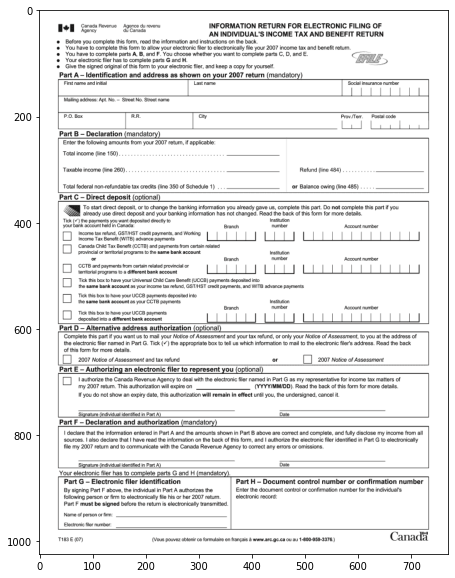

In [ ]:
img_path = 'https://www.signnow.com/preview/14/715/14715322/large.png'
img = download_image(img_path)
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

##### **Q1.a** Try to run the `ocr_patch` function defined above on entire test 

---

image. You may need to set `crop = None` and `viz = True` to vizualize the image. What do see, what peculiar features do you see in the image. [5]

**Answer**

1024 770


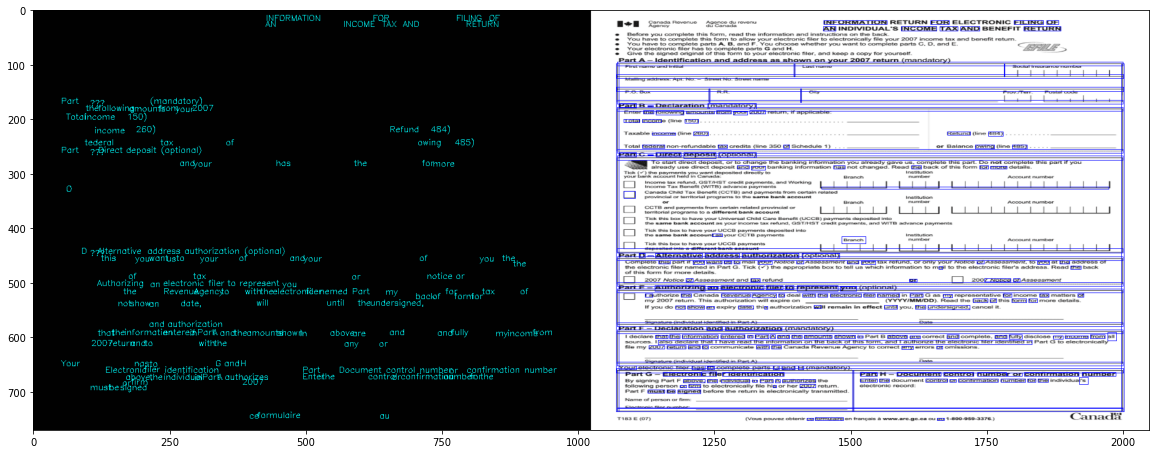

[('Bem', [48, 20, 88, 31], 0.34), ('gegen', [106, 20, 194, 25], 0.0), ('gece', [211, 20, 254, 31], 0.09), ('greens', [254, 20, 303, 31], 0.3), ('INFORMATION', [427, 19, 543, 26], 0.9), ('RETURS', [549, 19, 617, 26], 0.59), ('FOR', [623, 19, 657, 26], 0.82), ('ELECTRONIC', [663, 19, 770, 26], 0.8), ('FILING', [776, 19, 830, 26], 0.9), ('OF', [836, 19, 858, 26], 0.95), ('“', [218, 28, 224, 31], 0.12), ('AN', [426, 30, 449, 38], 0.93), ('INDIVIDUAL’S', [455, 30, 564, 38], 0.47), ('INCOME', [569, 30, 634, 38], 0.96), ('TAX', [640, 30, 673, 38], 0.95), ('AND', [678, 30, 713, 38], 0.95), ('BENEFIT', [718, 30, 789, 38], 0.79), ('RETURN', [794, 30, 862, 38], 0.96), ('getore', [67, 41, 105, 56], 0.0), ('zo', [110, 43, 131, 49], 0.27), ('comptes', [127, 42, 197, 56], 0.41), ('tas', [198, 42, 214, 56], 0.65), ('form,', [219, 41, 252, 56], 0.6), ('rane', [254, 41, 302, 56], 0.45), ('ormaton', [307, 41, 372, 56], 0.34), ('ane', [377, 42, 399, 48], 0.41), ('etna', [396, 41, 484, 56], 0.0), ('2', [47

In [ ]:
# Code here
out = ocr_patch(img, crop = None, scale = 1, viz = True)
print([i for i in zip(out['text'],out['bbox'],out['conf']) if i[0] != ''])

##### **Q1.b** Try scaling the image using the `scale` parameter. Does scaling help? Why do you think it does/doesn't? [10]

**Answer**

1024 770


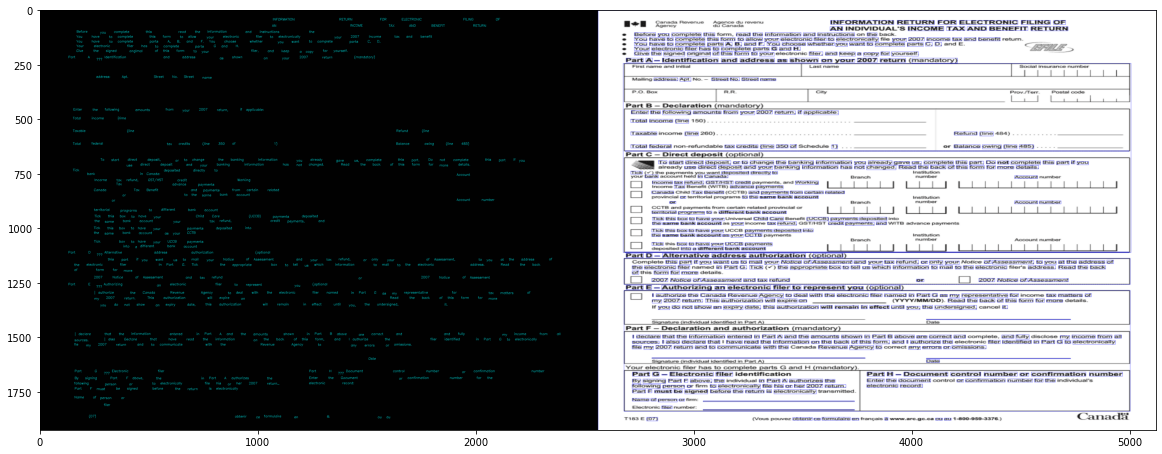

[('Bel', [120, 49, 220, 78], 0.48), ('sonst', [264, 49, 364, 62], 0.0), ('feewes', [375, 49, 485, 62], 0.0), ('Agee', [528, 49, 625, 79], 0.34), ('ds', [621, 49, 668, 78], 0.71), ('wre', [675, 52, 759, 62], 0.44), ('INFORMATION', [1067, 47, 1357, 66], 0.95), ('RETURN', [1372, 47, 1543, 66], 0.95), ('FOR', [1559, 47, 1644, 66], 0.96), ('ELECTRONIC', [1658, 47, 1926, 66], 0.95), ('FILING', [1941, 47, 2075, 66], 0.96), ('OF', [2090, 47, 2145, 66], 0.96), ('°', [286, 68, 296, 81], 0.63), ('.', [347, 69, 352, 81], 0.13), ('AN', [1064, 76, 1122, 94], 0.92), ('INDIVIDUAL‘S', [1136, 75, 1410, 95], 0.8), ('INCOME', [1422, 75, 1586, 95], 0.95), ('TAX', [1599, 76, 1683, 94], 0.96), ('AND', [1693, 76, 1783, 94], 0.95), ('BENEFIT', [1795, 76, 1972, 94], 0.94), ('RETURN', [1986, 76, 2156, 95], 0.95), ('Before', [167, 103, 264, 119], 0.94), ('you', [275, 107, 326, 123], 0.96), ('complete', [338, 104, 473, 123], 0.94), ('this', [484, 104, 536, 119], 0.95), ('form,', [546, 103, 621, 120], 0.69), ('read

In [ ]:
# Code here
out = ocr_patch(img, crop = None, scale = 2.5, viz = True)
print([i for i in zip(out['text'],out['bbox'],out['conf']) if i[0] != ''])

##### **Q2** Try to analyze the text from the Q1.a as follows, are there non dictionary words? What kind of words are low confidence and which are high? What is the overall confidence trend with scale. [15]

*Hint* You can use [`pyenchant`](https://pyenchant.github.io/pyenchant/) for this.  

*Bonus:* Try some advanced analysis, and see if there are interesting patterns. This part is open ended for your own curiosity. 

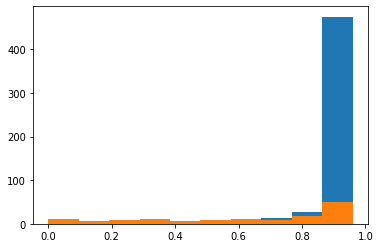

In [ ]:
# Code here
import enchant
text = out["text"]
conf = out["conf"]
eng_dict = enchant.Dict("en_US")

checks =[]
confs = []

for t,c in zip(text, conf):
  if len(t)>0:
    checks.append(eng_dict.check(t))
    confs.append(c)


from matplotlib import pyplot as pyplot
plt.hist([confs[i] for i, x in enumerate(checks) if x] )
plt.hist([confs[i] for i, x in enumerate(checks) if not x] )
plt.show()

##### **Q3 a** Implement cropping in `ocr_patch` function below and try out a few random crops. Add the images to your report. [10]
##### **Q3.b** How does the quality of detection change in the crop, how do the confidences change? [10]

200 100


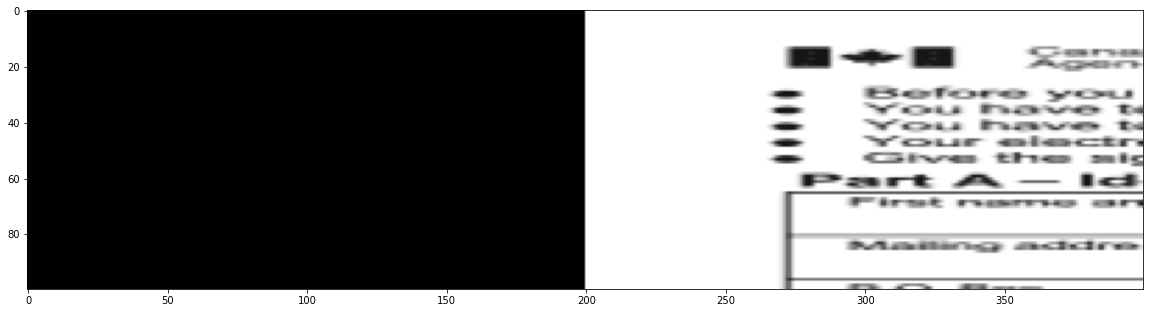

In [ ]:
out = ocr_patch(img, crop = [0, 0, 100, 200], scale = 1, viz = True)


### Part 2: Text Localization [60]

You may have seen, that the crops are more meaningful. This is because OCR performs better without a lot of background context. Infact tesseract tries to do it using moslty classical CV techniques. We will now use deep learning to get better localization, and see how our OCR quality improves. Note that it takes about a minute for the models to download.

publaynet_dit-b_mrcnn.pth: 453MB [00:25, 17.6MB/s]                           
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


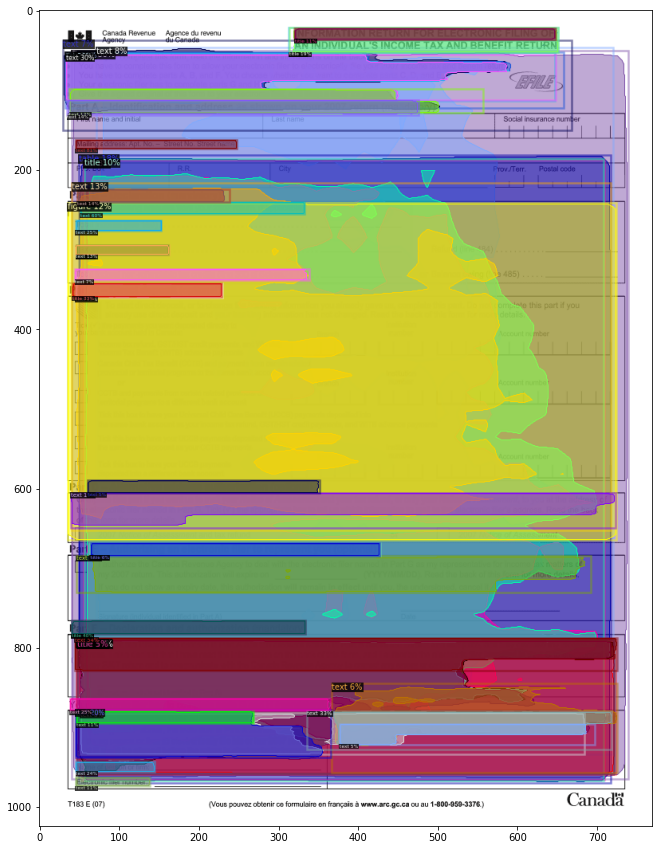

In [ ]:
import sys
sys.path.append("/content/unilm")

import cv2

from unilm.dit.object_detection.ditod import add_vit_config

import torch

from detectron2.config import CfgNode as CN
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultPredictor

# Step 1: instantiate config
cfg = get_cfg()
add_vit_config(cfg)
cfg.merge_from_file("/content/unilm/dit/object_detection/publaynet_configs/maskrcnn/maskrcnn_dit_base.yaml")

# Step 2: add model weights URL to config
cfg.MODEL.WEIGHTS = "https://layoutlm.blob.core.windows.net/dit/dit-fts/publaynet_dit-b_mrcnn.pth"

# Step 3: set device
device = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.DEVICE = device

# Step 4: define model
predictor = DefaultPredictor(cfg)

# Step 5: run inference
img_path = 'https://www.signnow.com/preview/14/715/14715322/large.png'
img = download_image(img_path)

md = MetadataCatalog.get(cfg.DATASETS.TEST[0])

if cfg.DATASETS.TEST[0]=='icdar2019_test':
    md.set(thing_classes=["table"])
else:
    md.set(thing_classes=["text","title","list","table","figure"])

output = predictor(img)["instances"]

# Step 5: run visualizer
v = Visualizer(img[:, :, ::-1],
                md,
                scale=1.0,
                instance_mode=ColorMode.SEGMENTATION)
result = v.draw_instance_predictions(output.to("cpu"))
result_image = result.get_image()[:, :, ::-1]

plt.figure(figsize=(15,15))
plt.imshow(result_image)
plt.show()

##### **Q4.a** Use the outputs from above to crop the image and run tesseract. Do we get better predictions now? How does the runtime change. What can you do to improve the predictions?  [10]

##### **Q4.b**  Comment on the speed - accuracy tradeoff. Do we miss parts of the image, why do you think this is happening. Add relevant images along with your answer. [5]

*Note 1:* you can also use the object detection model as well. This may help with the runtime consideration and predictions. 

*Hint: You may need to remove some redundant detections above, how would you do that.*

*Bonus:* Try a different model, by changing step 1 and 2. You may use paths from [here](https://github.com/microsoft/unilm/tree/master/dit/text_detection) [10]

In [ ]:
bboxes = output.get("pred_boxes").tensor.cpu().numpy().astype(int)
scores = output.get("scores").cpu().numpy()


##### **Q5.a** Now let's see how handwritten text on this form changes our predicitons. Download the file from the link and fill it up arbitary data (use ipad, or print it, fill it and upload). [10]

*Bonus:* you can fill some parts  of the document in another language. [5]




In [ ]:
# code here


In [ ]:
from google.colab import files
uploaded = files.upload() #Note this may not work in firefox so you may have to upload manually under files on the left

##### **Q5.b** Run `ocr_patch`  on whole image and comment on how the handwritten parts look like. Add image in the report. [5]

##### **Q5.c** Run our localization model and see if we are able to localize the handwritten parts well. Add some images in the report. [10]

*Bonus 1:* If you filled the some parts of the form in another language, how does our approch work there? [5]

*Bonus 2:* How does a form filled with the ipad, vs an image of a print perform. Which do you expect to perform better? [5]


##### **Q6** What are some potential sources of bias that may lead to bad predictions? What are some ways to alleviate them? [15]
*Hint: Comment on image quality, type of data used in the DiT paper, language of data vs. prediction.*

**Answer**

